# Import librairies

In [12]:
# Librairies for basics manipulation on file
import os
import sys
import inspect
from os import listdir
from os.path import isfile, join
import six

#Math and array and data manipulation librairies
import math
import numpy as np
import pandas as pd
from random import sample
import random

# Images librairies
import cv2
from easyimages import EasyImageList

# Plots librairies
from matplotlib import pyplot as plt
#plt.rcParams["figure.figsize"] = (10,10)
import seaborn as sns
import plotly.graph_objects as go
from scipy.interpolate import griddata
import plotly.offline as pyo
import plotly.io as pio

# Add missing modules
sys.modules['sklearn.externals.six'] = six
# ML Librairies
import mlrose

# Analysis of images

__The aim of this part is to have a small anaylis on the 512*512 PNG images before using them__

## Import of images

TODO:
Explain what is the dataset about, how it was exported from DICOM to PNG (what is DICOM and PNG)

In [13]:
# Path to the dataset of png images, (to change)
path = "../kaggle_dataset"

In [14]:
# Take the n first files names of the dataset of images
n_files = 30
onlyfiles = [f for f in listdir(path)[:n_files] if isfile(join(path, f))]

In [15]:
# Load the list of images
imgs = []
for file in onlyfiles:
    img = cv2.imread(f"{path}/{file}")
    imgs.append(img)
# Print the Shape of image as it is a Numpy Array
print("Image Shape:", img.shape)

Image Shape: (512, 512, 3)


## Quick preview of images

In [16]:
Li = EasyImageList.from_folder(path)
Li.html(sample=800, size=30)

__Here we can see that it seems that the data don't have missing or incoherent images (the sample is not necessary representative from the dataset since we only take 800 images from more than 50k). It appears that images have very different shapes, contrast, luminosity. It is also worth mentioning that black pixels represent on many screenings an important part of the image.__

## Display some images with histograms

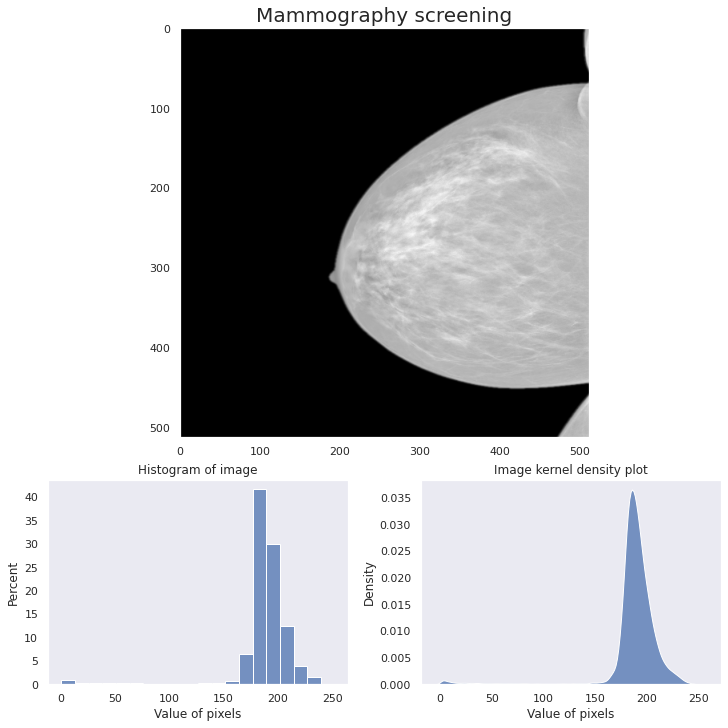

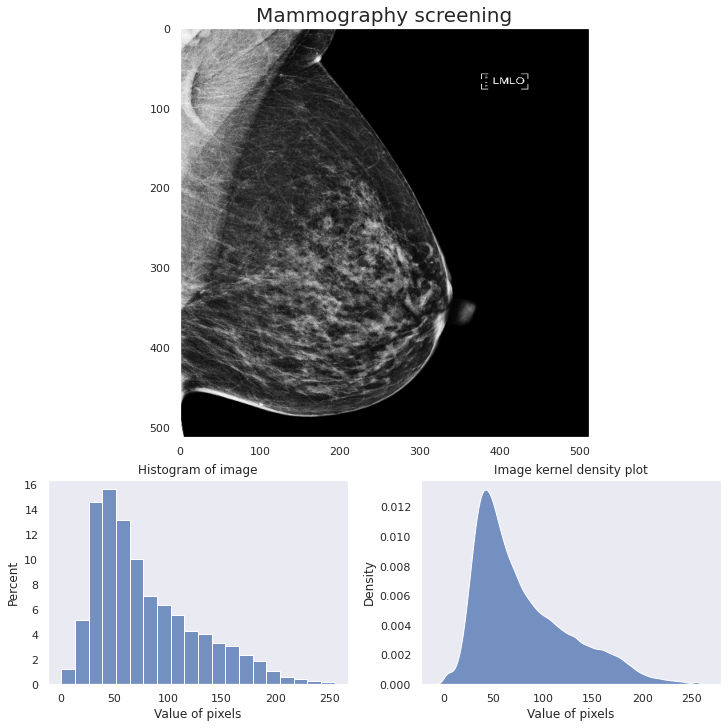

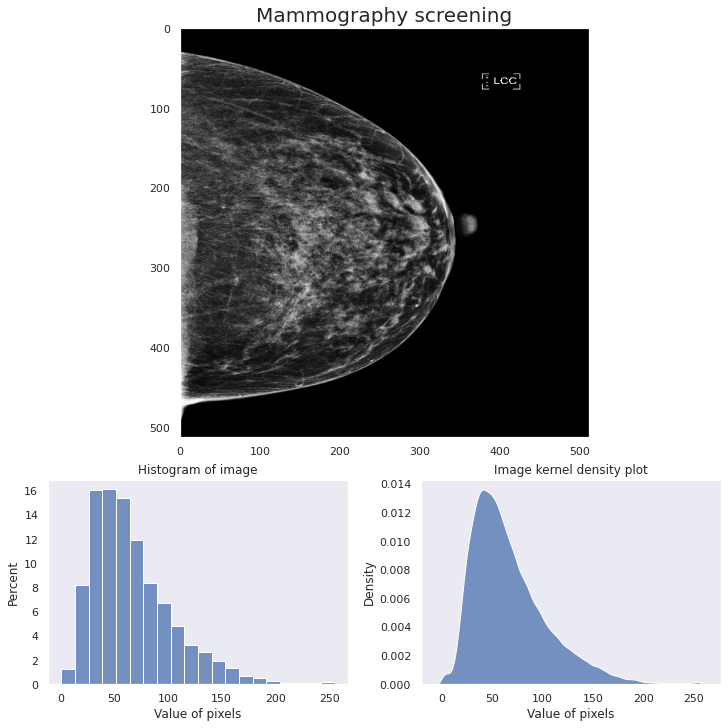

In [32]:
# Display n images with associated histogramms and kde plots
n_images = 3
seed = 53
random.seed(seed)
imgs_sample = sample(imgs,n_images)

for img in imgs_sample:
    sns.set_style("dark")
    fig5 = plt.figure(constrained_layout=True)
    widths = [20, 20]
    heights = [20, 10]
    spec5 = fig5.add_gridspec(ncols=2, nrows=2, width_ratios=widths,
                              height_ratios=heights)

    ax = fig5.add_subplot(spec5[0, :])
    ax.set_title("Mammography screening")
    ax.title.set_size(20)
    plt.imshow(img)


    ax = fig5.add_subplot(spec5[1, 0])
    sns.histplot(img[np.where(img!=0)].flatten(), bins=20, stat = "percent")
    ax.set_xlabel("Value of pixels")
    ax.set_title("Histogram of image")

    ax = fig5.add_subplot(spec5[1, 1])
    sns.kdeplot(data=img[np.where(img!=0)].flatten(), multiple="stack")
    ax.set_title("Image kernel density plot")
    ax.set_xlabel("Value of pixels")
    plt.show()   

__We could see that images seem to have a large part of pixels that has the value 0 (we remove them from histograms to ease the read) and they seem to have different histograms shape (different range of pixels values, different repartitions and different contrasts...)__

## Normalized images

In [29]:
imgs_equzd_sample = [cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)) for img in imgs_sample]
#img_eqz = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#img_equz = cv2.equalizeHist(img_eqz)

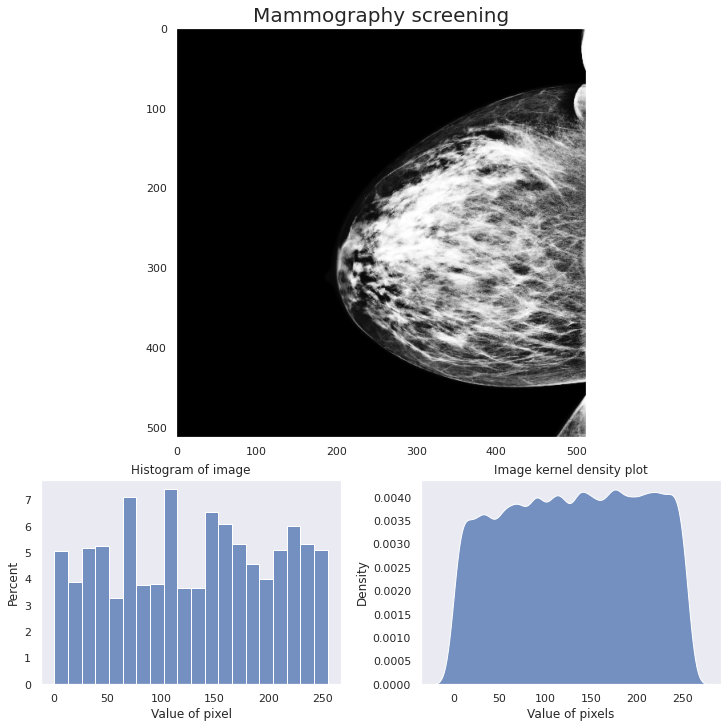

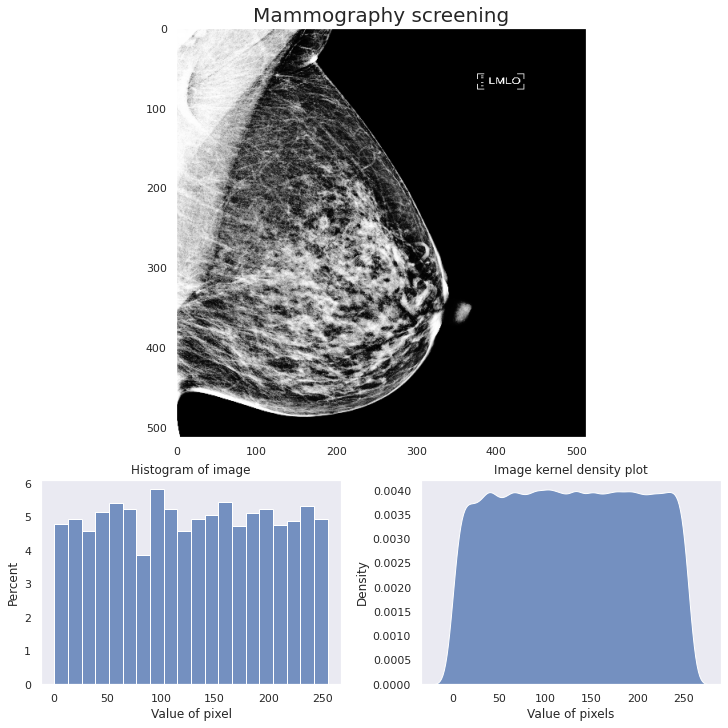

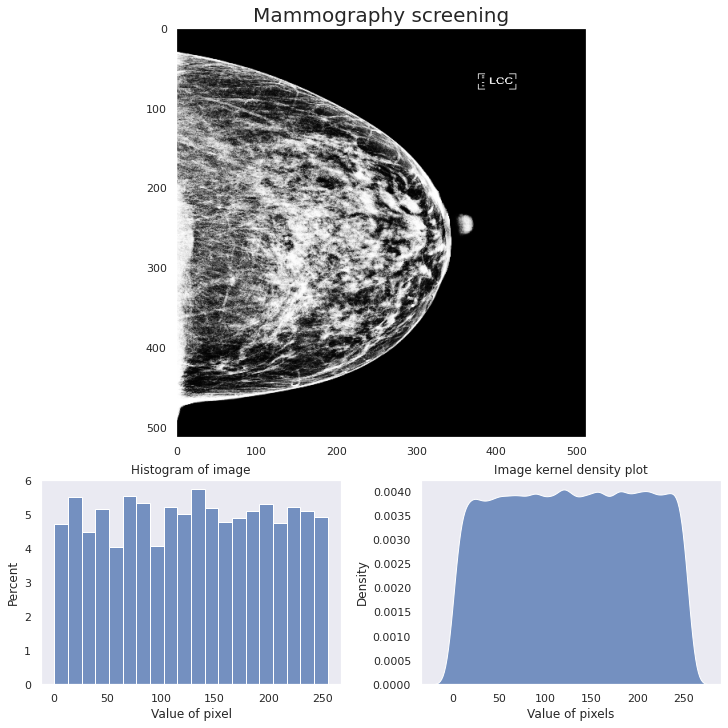

In [33]:
for img in imgs_equzd_sample:
    sns.set_style("dark")
    fig5 = plt.figure(constrained_layout=True)
    widths = [20, 20]
    heights = [20, 10]
    spec5 = fig5.add_gridspec(ncols=2, nrows=2, width_ratios=widths,
                              height_ratios=heights)

    ax = fig5.add_subplot(spec5[0, :])
    ax.set_title("Mammography screening")
    ax.title.set_size(20)
    plt.imshow(img, cmap="gray")


    ax = fig5.add_subplot(spec5[1, 0])
    sns.histplot(img[np.where(img!=0)].flatten(), bins=20, stat = "percent")
    ax.set_xlabel("Value of pixel")
    ax.set_title("Histogram of image")

    ax = fig5.add_subplot(spec5[1, 1])
    sns.kdeplot(data=img[np.where(img!=0)].flatten(), multiple="stack")
    ax.set_title("Image kernel density plot")
    ax.set_xlabel("Value of pixels")
    plt.show()


__After having equalized histograms, we could see that range and contrast in images seem to be more similar between images, it could be intersting to see if it enhances results in models__

## 3D histograms

__This part is too have a deeper view on how different are histograms of images, by using plotting histograms in a 3D space and by interpolating to have a surface, since the placement of images' histograms are arbitrary on the 3D space, one could use an optimization approach so that histograms that are similar are closer on the 3D space (detailed later)__ 

The following cell is not mandatory to run, it computes the distance between histograms of images (with MSE) and then uses a TSP model to smoothen the surface (reduce/avoid high variation between 2 histograms for 2 screenings), be careful, don't use it if there are too many screenings (high complextity for the algorithm)
You can find more details there: https://mlrose.readthedocs.io/en/stable/source/tutorial2.html

In [39]:
nbins = 100
# Creation of histograms of images to see the distance between images repartition of pixels (with MSE) 
L = np.array([np.histogram(img.flatten(),bins=nbins)[0] for img in imgs])
Dist = np.array([[math.sqrt(np.square(np.subtract(elem1,elem2)).mean()) for elem1 in L] for elem2 in L])

# Optimization model doesn't accept 0 on diagonal terms
for i in range(Dist.shape[0]):
    Dist[i][i]=10e8

# Reorganization of format of distances so that it could be trained
Dist_mlrose = [(i,j,Dist[i,j])for i in range(Dist.shape[0]) for j in range(Dist.shape[1])]

fitness_dists = mlrose.TravellingSales(distances = Dist_mlrose)
problem_fit = mlrose.TSPOpt(length = 30, fitness_fn = fitness_dists,
                            maximize=False)

# Get the best ordering (here genetic algorithm)
best_state, best_fitness = mlrose.genetic_alg(problem_fit, mutation_prob = 0.2, max_attempts = 30,random_state = 2)

In [40]:
# Create grids of histograms' points for 3D plot
nbins = 100
histograms = np.array([np.histogram(img[np.where(img>30)].flatten(),bins=nbins)[0] for img in imgs])
coordinates = np.array([np.histogram(img[np.where(img>3)].flatten(),bins=nbins)[1] for img in imgs])
# Rerange coordinates of histograms to be in the midle of the bar
coordinates2 = np.array([[(coordinates[i,j]+coordinates[i,j+1])/2 for j in range(coordinates.shape[1]-1)] for j in range(coordinates.shape[0])])

# To comment if not surface smoothing is done
histograms = histograms[best_state]
coordinates = coordinates[best_state]

# Space the histograms in the 3D space
width = 1
coordinateY = np.array([[width*n for i in range(coordinates2.shape[1])] for n in range(coordinates.shape[0])])


It could be that plotly doesn't render in offline notebooks in Jupyter Lab, you will need to install the extension for plotly in Jupyter lab with the next cell, cf. https://stackoverflow.com/questions/52771328/plotly-chart-not-showing-in-jupyter-notebook

In [41]:
#!jupyter labextension install jupyterlab-plotly

In [60]:
# Set notebook mode to work in offline
pyo.init_notebook_mode()


# Dimension of coordinates of histograms
x = coordinates2.flatten()
# Dimension of the images (each unit*width is a histogram from one image)
y = coordinateY.flatten()
# Number of pixels in the histogram
z = histograms.flatten()


xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)

X,Y = np.meshgrid(xi,yi)

Z = griddata((x,y),z,(X,Y), method='cubic')



pio.renderers.default = 'iframe'
fig = go.Figure(go.Surface(x=xi,y=yi,z=Z))
fig.update_layout(scene = dict(
                    xaxis = dict(
                         backgroundcolor="rgb(200, 200, 230)",
                         gridcolor="white",
                         showbackground=True,
                         zerolinecolor="white",),
                    yaxis = dict(
                        backgroundcolor="rgb(230, 200,230)",
                        gridcolor="white",
                        showbackground=True,
                        zerolinecolor="white"),
                    zaxis = dict(
                        backgroundcolor="rgb(230, 230,200)",
                        gridcolor="white",
                        showbackground=True,
                        zerolinecolor="white",),),
                    width=700,
                    margin=dict(
                    r=10, l=10,
                    b=10, t=10)
                  )

fig.update_layout(scene = dict(
                    xaxis_title='Coordinates in the histograms',
                    yaxis_title='Sequence of images/histograms',
                    zaxis_title='Number of pixels'),
                  font = dict(color = "black",size  =10), 
                  )
fig.update_layout(title = dict(text="3D representation of histograms of n images", 
                               font=dict(color = "black",size  =20),xanchor=  'center',
        yanchor= 'top',y=0.9,
        x=0.5))

fig.show()

# Some basics analysis on images

In [17]:
train_df = pd.read_csv("data/train.csv")

In [20]:
train_df.head(5)

site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True

In [19]:
train_df["view"].value_counts()

MLO    27903
CC     26765
AT        19
LM        10
ML         8
LMO        1
Name: view, dtype: int64

In [46]:
#!pip3 install ipywidgets

In [47]:
#!jupyter labextension install jupyterlab-plotly